# ECE 47300 Assignment 5 Exercise

Your Name: Paloma Arellano

## Exercise 0: Train your model on GPU (0 points)

For some tasks in this assignment, it can take a long time if you run it on CPU. For example, based on our test on Exercise 3 Task 4, it will take roughly 2 hours to train the full model for 1 epoch on CPU. Hence, we highly recommend you try to train your model on GPU.

To do so, first you need to enable GPU on Colab (this will restart the runtime). Click `Runtime`-> `Change runtime type` and select the `Hardware accelerator` there.  You can then run the following code to see if the GPU is correctly initialized and available.

**Note**: If you would like to avoid GPU overages on Colab, we would suggest writing and debugging your code before switching on the GPU runtime. Otherwise, the time you spent debugging code will likely count against your GPU usage. Once you have the code running, you can switch on the GPU runtime and train the model much faster.

In [ ]:
import torch

print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


### You must manually move your model and data to the GPU (and sometimes back to the cpu)
After setting the GPU up on colab, then you should put your **model** and **data** to GPU. We give a simple example below. You can use `to` function for this task. See [torch.Tensor.to](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to move a tensor to the GPU (probably your mini-batch of data in each iteration) or [torch.nn.Module.to](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.to) to move your NN model to GPU (assuming you create subclass [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)). Note that `to()` of tensor returns a NEW tensor while `to` of a NN model will apply this in-place. To be safe, the best semantics are `obj = obj.to(device)`. For printing, you will need to move a tensor back to the CPU via the `cpu()` function.

Once the model and input data are on the GPU, everything else can be done the same.  This is the beauty of PyTorch GPU acceleration.  None of the other code needs to be altered.

To summarize, you need to 1) enable GPU acceleration in Colab, 2) put the model on the GPU, and 3) put the input data (i.e., the batch of samples) onto the GPU using `to()` after it is loaded by the data loaders (usually you only put one batch of data on the GPU at a time).

In [ ]:
import torch.nn as nn
rand_tensor = torch.rand(5,2)
simple_model = nn.Sequential(nn.Linear(2,10), nn.ReLU(), nn.Linear(10,1))
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

# device = torch.device('cuda')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# ----------- <Your code> ---------------
# Move rand_tensor and model onto the GPU device
rand_tensor = rand_tensor.to(device)
simple_model = simple_model.to(device)

# --------- <End your code> -------------
print(f'input is on {rand_tensor.device}')
print(f'model parameters are on {[param.device for param in simple_model.parameters()]}')
print(f'output is on {simple_model(rand_tensor).device}')

input is on cpu
model parameters are on [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
output is on cpu
input is on cuda:0
model parameters are on [device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0), device(type='cuda', index=0)]
output is on cuda:0


Here is a helper function to print the accuracy given a model and loader

In [ ]:
def print_accuracy(model, testloader):
  # Note device should be defined globally from the previous cell
  model.to(device)
  correct, total = 0, 0
  with torch.no_grad():
    for data in testloader:
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

## Exercise 1: Why use a CNN rather than only fully connected layers? (40 points)

In this exercise, you will build two models for the **MNIST** dataset: one uses only fully connected layers and another uses a standard CNN layout (convolution layers everywhere except the last layer is fully connected layer). Note, you will need to use cross entropy loss as your objective function. The two models should be built with roughly the same accuracy performance, your task is to compare the number of network parameters (a huge number of parameters can affect training/testing time, memory requirements, overfitting, etc.).

### Task 1: Following the structure used in the instructions, you should create

*   One network named **OurFC** which should consist with only fully connected layers

  *   You should decide how many layers and how many hidden dimensions you want in your network 
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   There is no need to make the neural network unnecessarily complex, your total training time should no longer than 3 mins

*   Another network named **OurCNN** which applys a standard CNN structure
  *   Again, you should decide how many layers and how many channels you want for each layer.
  *   Your final accuracy on the test dataset should lie roughly around 90% ($\pm$2%)
  *   A standard CNN structure can be composed as **[Conv2d, MaxPooling, ReLU] x num_conv_layers + FC x num_fc_layers**

* Train and test your network on MNIST data as in the instructions
* You are **required** to print out the loss in the training and loss+accuracy in the test as in the instructions.
* The code below will also print out the number of parameters for both neural networks to allow comparison.
* (You can use multiple cells if helpful but make sure to run all of them to receive credit.)

In [ ]:
# ----------- <Your code> ---------------
# Download MNIST and transformation
import torchvision

"""
Here the transform is a pipeline containing two seperate transforms: 
1. Transform the data into tensor type
2. Normalize the dataset by a giving mean and std. 
  (Those number is given as the global mean and standard deviation of MNIST dataset)
"""
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                      torchvision.transforms.Normalize((0.1307,),(0.3081,))])

train_dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('data', train=False, download=True, transform=transform)

# print(train_dataset)

batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

# print(train_loader)

In [ ]:
# ----------- <Your code> ---------------
import torch.nn as nn
import torch.nn.functional as F

class OurFC(nn.Module):
    # your code here
    def __init__(self):
      super(OurFC, self).__init__()
      self.fc = nn.Linear(1 * 28 * 28, 10)  # ((batchsize * channels * image width * image height), 10 = number of outputs (0-9))

    def forward(self, x):
      x = x.view(-1, 784)      # x now has shape (batchsize x 784)
      x = F.relu(self.fc(x))     # x has shape (batchsize x 10)
      return F.log_softmax(x,-1) 
    # pass # remove pass after you finish your code
    
class OurCNN(nn.Module):
    # your code here
    def __init__(self):
        super(OurCNN, self).__init__()
        self.conv = nn.Conv2d(1, 3, kernel_size=5)
        self.fc = nn.Linear(432, 10)
        self.conv1 = nn.Conv2d(3, 3, kernel_size=5)
        self.fc1 = nn.Linear(3072, 10)

    def forward(self, x):
        #print("x = " + str(x.size()))
        x = self.conv(x)        # x now has shape (batchsize x 3 x 24 x 24)
        #print("conv(x) = " + str(x.size()))
        x = F.relu(F.max_pool2d(x,2))  # x now has shape (batchsize x 3 x 12 x 12)
        
        x = x.view(-1, 432)      # x now has shape (batchsize x 432)
        x = F.relu(self.fc(x))     # x has shape (batchsize x 10)
        return F.log_softmax(x,-1) 
        #pass # remove pass after you finish your code


In [ ]:
# ----------- <Your code> ---------------
def train(classifier, epoch):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):

    optimizer.zero_grad()
    output = classifier(images)
    loss = F.nll_loss(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')


def test(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

In [ ]:
# ----------- <Your code> ---------------
import torch.optim as optim

train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

classifier = OurFC()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)


Epoch 1: [0/60000] Loss: 2.3194797039031982
Epoch 1: [6400/60000] Loss: 0.300398051738739
Epoch 1: [12800/60000] Loss: 0.33517929911613464
Epoch 1: [19200/60000] Loss: 0.5488245487213135
Epoch 1: [25600/60000] Loss: 0.19002513587474823
Epoch 1: [32000/60000] Loss: 0.4128912389278412
Epoch 1: [38400/60000] Loss: 0.33004146814346313
Epoch 1: [44800/60000] Loss: 0.2375909835100174
Epoch 1: [51200/60000] Loss: 0.11440679430961609
Epoch 1: [57600/60000] Loss: 0.3480956554412842
Test result on epoch 1: Avg loss is 0.29736049728393554, Accuracy: 91.41000366210938%
Epoch 2: [0/60000] Loss: 0.22195270657539368
Epoch 2: [6400/60000] Loss: 0.1573459506034851
Epoch 2: [12800/60000] Loss: 0.2569083273410797
Epoch 2: [19200/60000] Loss: 0.3088001608848572
Epoch 2: [25600/60000] Loss: 0.15871712565422058
Epoch 2: [32000/60000] Loss: 0.20846867561340332
Epoch 2: [38400/60000] Loss: 0.2954784631729126
Epoch 2: [44800/60000] Loss: 0.11659292131662369
Epoch 2: [51200/60000] Loss: 0.42219460010528564
Epoc

In [ ]:
# ----------- <Your code> ---------------
train_losses = []
train_counter = []
test_losses = []
test_counter = []
max_epoch = 3

classifier = OurCNN()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.8)

for epoch in range(1, max_epoch+1):
  train(classifier, epoch)
  test(classifier, epoch)


Epoch 1: [0/60000] Loss: 2.34623384475708
Epoch 1: [6400/60000] Loss: 0.629063606262207
Epoch 1: [12800/60000] Loss: 0.545032799243927
Epoch 1: [19200/60000] Loss: 0.5630946159362793
Epoch 1: [25600/60000] Loss: 0.4520608186721802
Epoch 1: [32000/60000] Loss: 0.5070391297340393
Epoch 1: [38400/60000] Loss: 0.3408866822719574
Epoch 1: [44800/60000] Loss: 0.39003199338912964
Epoch 1: [51200/60000] Loss: 0.503898024559021
Epoch 1: [57600/60000] Loss: 0.4253750741481781
Test result on epoch 1: Avg loss is 0.3467552886962891, Accuracy: 96.12000274658203%
Epoch 2: [0/60000] Loss: 0.4598082900047302
Epoch 2: [6400/60000] Loss: 0.36421874165534973
Epoch 2: [12800/60000] Loss: 0.3090541958808899
Epoch 2: [19200/60000] Loss: 0.08299479633569717
Epoch 2: [25600/60000] Loss: 0.1390698105096817
Epoch 2: [32000/60000] Loss: 0.19516479969024658
Epoch 2: [38400/60000] Loss: 0.08857384324073792
Epoch 2: [44800/60000] Loss: 0.051254790276288986
Epoch 2: [51200/60000] Loss: 0.07874339073896408
Epoch 2: [

In [ ]:
ourfc = OurFC()
total_params = sum(p.numel() for p in ourfc.parameters())
print(f'OurFC has a total of {total_params} parameters')

ourcnn = OurCNN()
total_params = sum(p.numel() for p in ourcnn.parameters())
print(f'OurCNN has a total of {total_params} parameters')

OurFC has a total of 7850 parameters
OurCNN has a total of 35366 parameters


Questions (0 points, just for understanding): Which one has more parameters?  Which one is likely to have less computational cost when deployed? Which one took longer to train?

## Exercise 2: Train classifier on CIFAR-10 data. (30 points)
Now, lets move our dataset to color images. CIFAR-10 dataset is another widely used dataset. Here all images have colors, i.e each image has 3 color channels instead of only one channel in MNIST. You need to pay more attention to the dimension of the data as it passes through the layers of your network.

### Task 1: Create data loaders 
* Load CIFAR10 train and test datas with appropriate composite transform where the normalize transform should be `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])`.
* Set up a `train_loader` and `test_loader` for the CIFAR-10 data with a batch size of 9 similar to the instructions.
* The code below will plot a 3 x 3 subplot of images including their labels. (do not modify)

Files already downloaded and verified
Files already downloaded and verified


C:\Users\conor\AppData\Local\Temp\ipykernel_22976\130041415.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


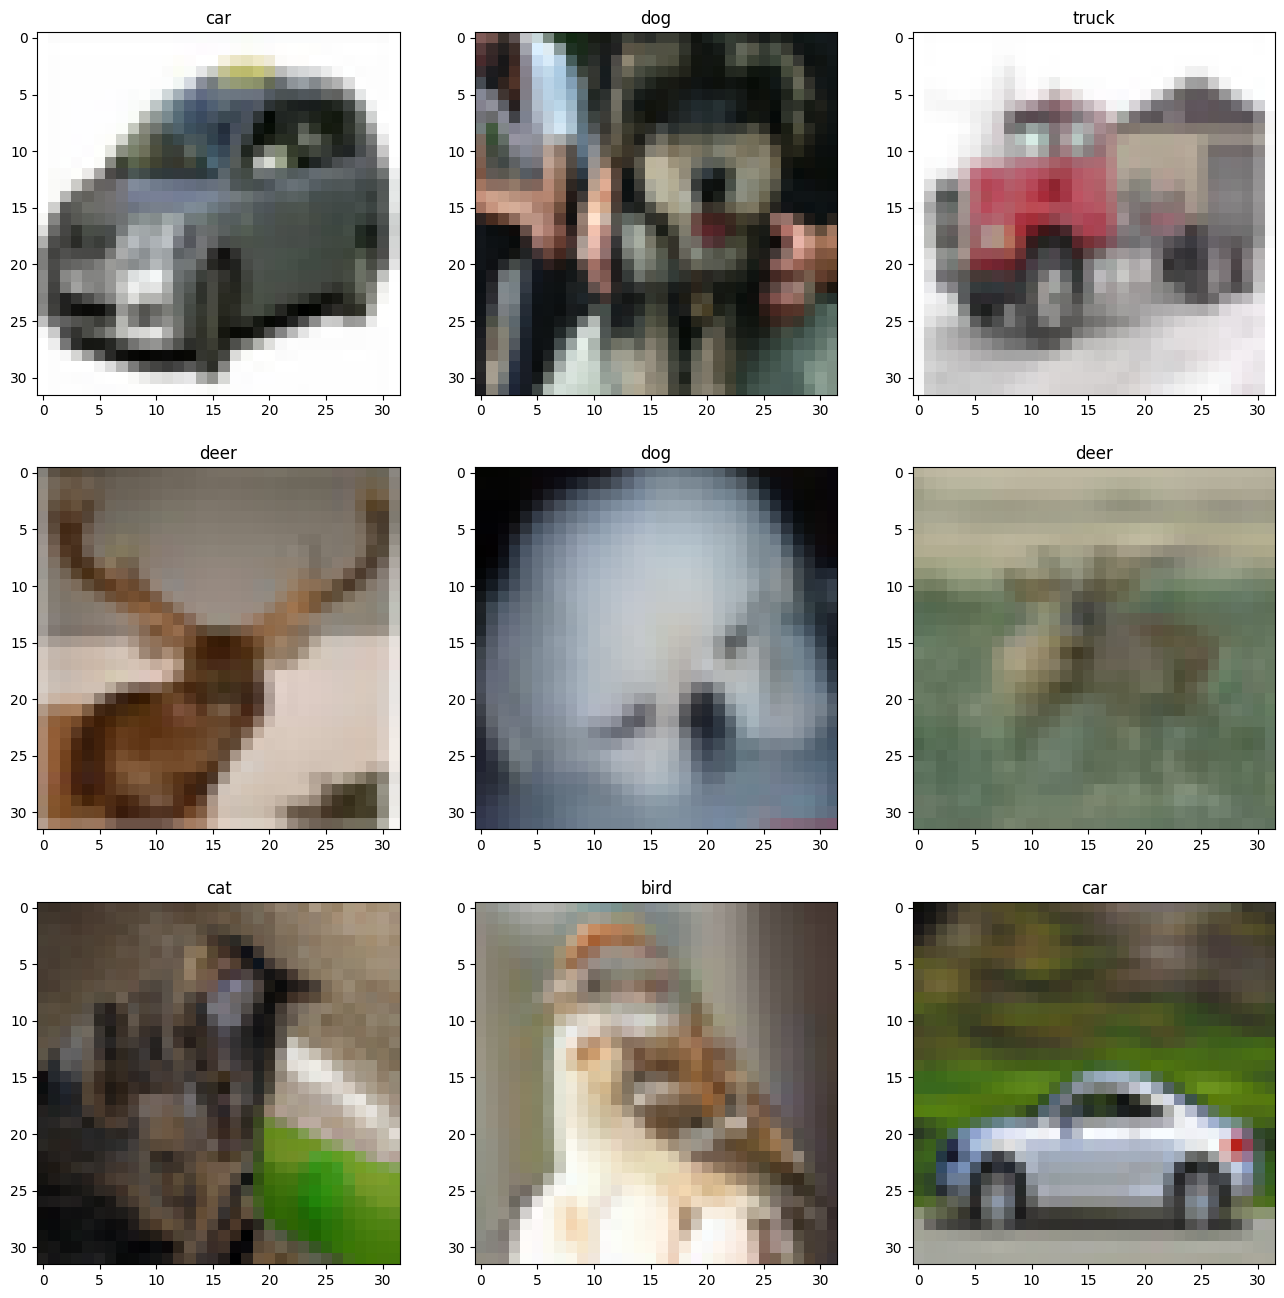

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create the appropriate transform, load/download CIFAR10 train and test datasets with transform
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

# ----------- <End Your code> ---------------

# Define trainloader and testloader
# ----------- <Your code> ---------------
batch_size_train, batch_size_test = 64, 1000

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)
# ----------- <End Your code> ---------------

# Code to display images
batch_idx, (images, targets) = next(enumerate(train_loader)) #fix!!!!!
fig, ax = plt.subplots(3,3,figsize = (16,16))
fig.set_size_inches(16,16)
for i in range(3):
  for j in range(3):
    image = images[i*3+j].permute(1,2,0)
    image = image/2 + 0.5
    ax[i,j].imshow(image)
    ax[i,j].set_title(f'{classes[targets[i*3+j]]}')
fig.show()

### Task 2: Create CNN and train it
Set up a convolutional neural network and have your data trained on it. You have to decide all the details in your network, overall your neural network should meet the following standards to receive full credit:

*   You should not use more than three convolutional layers and three fully connected layers
*   Accuracy on the test dataset should be **above** 50%



In [ ]:
# ----------- <Your code> ---------------
# CNN network
import torch.nn as nn
import torch.nn.functional as F

class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()
        # nn.Conv2d(in_channels, out_channels/n_filters, kernel_size)
        self.conv1 = nn.Conv2d(3, 6, 5)
        # nn.MaxPool2d(kernel_size, stride)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Input is (N, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x))) # (N, 6, 14, 14)
        x = self.pool(F.relu(self.conv2(x))) # (N, 16, 5, 5)
        x = x.view(-1, 16 * 5 * 5) # (N, 400)
        x = F.relu(self.fc1(x)) # (N, 120)
        x = F.relu(self.fc2(x)) # (N, 84)
        x = self.fc3(x) # (N, 10)
        return x


In [ ]:
# ----------- <Your code> ---------------
# Define net
net = myCNN()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

# ----------- <End Your code> ---------------

# This prints the accuracy of your model. 
print_accuracy(net, test_loader) #!!!FIX

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Accuracy of the network on the test images: 51 %


### Task 3: Plot misclassified test images
Plot some misclassified images in your test dataset:

*   select three images that are **misclassified** by your neural network
*   label each images with true label and predicted label
*   use `detach().cpu()` when plotting images if the image is in gpu

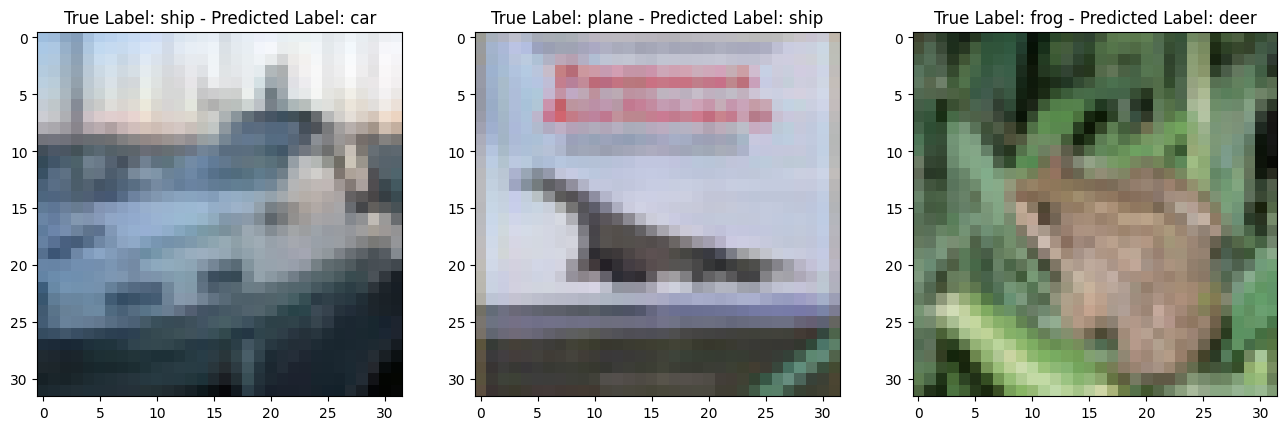

In [ ]:
# ----------- <Your code> ---------------

batch_idx, (images, targets) = next(enumerate(test_loader)) #fix!!!!!
fig, ax = plt.subplots(1,3,figsize = (16,16))
fig.set_size_inches(16,16)

num_not_correct = 0

net.to(device)
correct, total = 0, 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(predicted)
        #print(labels)
        for i in range(labels.shape[0]):
            if (predicted[i] != labels[i] and num_not_correct < 3):
                num_not_correct += 1
                image1 = images[i].detach().cpu().permute(1,2,0)
                image1 = image1/2 + 0.5
                ax[num_not_correct-1].imshow(image1)
                ax[num_not_correct-1].set_title(f'True Label: {classes[labels[i]]} - Predicted Label: {classes[predicted[i]]}')
        break


Questions (0 points): Are the mis-classified images also misleading to human eyes?

## Exercise 3: Transfer Learning (30 points)

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import time

In practice, people won't train an entire CNN from scratch, because it is relatively rare to have a dataset of sufficient size (or sufficient computational power). Instead, it is common to pretrain a CNN on a very large dataset and then use the CNN either as an initialization or a fixed feature extractor for the task of interest.

In this task, you will learn how to use a pretrained CNN for CIFAR-10 classification.

### Task1: Load pretrained model

`torchvision.models` (https://pytorch.org/vision/stable/models.html) contains definitions of models for addressing different tasks, including: image classification, pixelwise semantic segmentation, object detection, instance segmentation, person keypoint detection and video classification.

First, you should load the **pretrained** ResNet-18 that has already been trained on [ImageNet](https://www.image-net.org/) using `torchvision.models`. If you are interested in more details about Resnet-18, read this paper https://arxiv.org/pdf/1512.03385.pdf.

In [ ]:
# ----------- <Your code> ---------------
# Load the pretrained model here
resnet18 = models.resnet18(pretrained=True)
device = torch.device('cuda')
resnet18 = resnet18.to(device)

### Task2: Create data loaders for CIFAR-10

Then you need to create a modified dataset and dataloader for CIFAR-10. Importantly, the model you load has been trained on **ImageNet** and it expects inputs as mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be **at least** 224. So you need to preprocess the CIFAR-10 data to make sure it has a height and width of 224. Thus, you should add a transform when loading the CIFAR10 dataset (see [`torchvision.transforms.Resize`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Resize)).
This should be added appropriately to the `transform` you created in a previous task.

In [ ]:
# ----------- <Your code> ---------------
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((224, 224)),
                    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10('data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
device = torch.device('cuda')
resnet18 = resnet18.to(device)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_loader = torch.utils.data.DataLoader(trainset, batch_size=9,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=9,
                                         shuffle=False)

### Task3: Classify test data on pretrained model

Use the model you load to classify the **test** CIFAR-10 data and print out the test accuracy.

Don't be surprised if the accuracy is bad!

In [ ]:
# ----------- <Your code> ---------------
# print the accuracy of the pretrained model
def train2(classifier, epoch):

  classifier.train() # we need to set the mode for our model

  for batch_idx, (images, targets) in enumerate(train_loader):
    images = images.to(device)
    targets = targets.to(device)
    optimizer.zero_grad()
    output = classifier(images)
    loss = F.nll_loss(output, targets) # Here is a typical loss function (negative log likelihood)
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      train_losses.append(loss.item()) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 100 == 0: # We visulize our output every 10 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()}')
    
def test2(classifier, epoch):

  classifier.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, targets in test_loader:
      images = images.to(device)
      targets = targets.to(device)
      output = classifier(images)
      test_loss += F.nll_loss(output, targets, reduction='sum').item()
      pred = output.data.max(1, keepdim=True)[1] # we get the estimate of our result by look at the largest class value
      correct += pred.eq(targets.data.view_as(pred)).sum() # sum up the corrected samples
  
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  print(f'Test result on epoch {epoch}: Avg loss is {test_loss}, Accuracy: {100.*correct/len(test_loader.dataset)}%')

max_epoch = 3

for epoch in range(1, max_epoch+1):
  test2(resnet18, epoch)

Test result on epoch 1: Avg loss is 0.7757669360518455, Accuracy: 0.029999999329447746%
Test result on epoch 2: Avg loss is 0.7757669360518455, Accuracy: 0.029999999329447746%
Test result on epoch 3: Avg loss is 0.7757669360518455, Accuracy: 0.029999999329447746%


### Task 4: Fine-tune (i.e., update) the pretrained model for CIFAR-10

Now try to improve the test accuracy. We offer several possible solutions:

(1) You can try to directly continue to train the model you load with the CIFAR-10 training data. 

(2) For efficiency, you can try to freeze part of the parameters of the loaded models. For example, you can first freeze all parameters by

```
for param in model.parameters():
    param.requires_grad = False
```
and then unfreeze the last few layers by setting `somelayer.requires_grad=True`.

You are also welcome to try any other approach you can think of.


**Note:** You must print out the test accuracy and to get full credits, the test accuracy should be at least **80%**.

In [ ]:
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)
# ----------- <Your code> ---------------
for epoch in range(1):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

# ----------- <End your code> ---------------
end = time.time()
print(f'Finished Training after {end-start} s ')

epoch: 0
[1,  2000] loss: 1.724
[1,  4000] loss: 0.869
Finished Training after 140.3220431804657 s 


In [ ]:

print_accuracy(resnet18, test_loader)

Accuracy of the network on the test images: 88 %


Transfer learning by freezing the layers and only unfreezing the outer layers

In [ ]:
# ----------- <Your code> ---------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

for val, param in resnet18.state_dict().items():
    if 'fc' in val:
        continue
    param.requires_grad = False

for epoch in range(1):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
# ----------- <End Your code> ---------------

epoch: 0
[1,  2000] loss: 0.221
[1,  4000] loss: 0.257


In [ ]:

print_accuracy(resnet18, test_loader)

Accuracy of the network on the test images: 91 %
